In [1]:
import numpy as np
import math
import cmath
import tensorflow as tf
import random
import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Hiragino Sans'

/Users/yoshihiro/opt/anaconda3/envs/device/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#IQを付与したデータの作成

In [3]:
# def iq_imbalance(pha , amp):
#     delta_tem = np.random.beta(5, 2)
#     delta_tam = delta_tem * (np.pi / 180) * pha
    
#     epsilon_tem = np.random.beta(5, 2)
#     epsilon_tam = amp * epsilon_tem
            
#     return delta_tam, epsilon_tam

In [4]:
# #デバイス数
# N = 8
# #IQ-imbalanceのパラメータ
# pha=20
# amp=0.3
# #パラメータ保存用のリスト
# delta = np.empty((0, 1))
# epsilon = np.empty((0, 1))

# for i in range(N):
#     delta_tam , epsilon_tam = iq_imbalance(pha , amp)
    
#     delta = np.append(delta, delta_tam)
#     epsilon = np.append(epsilon, epsilon_tam)

In [5]:
# delta , epsilon

In [6]:
# #受信語データ保存
# np.savez(f'delta_and_epsilon.npz', delta, epsilon)

In [7]:
#受信語データ保存
npz = np.load('delta_and_epsilon.npz')

#データの格納
delta = npz['arr_0']
epsilon = npz['arr_1']

In [8]:
#学習データの生成

In [9]:
def message(a, b):
    
    if a == 2:
        #qpsk
        #メッセージ生成
        if b%4==0:
            message = np.array([[0, 0]])
        elif b%4==1:
            message = np.array([[0, 1]])
        elif b%4==2:
            message = np.array([[1, 0]])
        elif b%4==3:
            message = np.array([[1, 1]])
        
        #message = np.random.randint(0, 2, (1, a))
        x = 1.0-2*(message[0][0])
        y = 1.0-2*(message[0][1])
        
        s = (x + 1j * y)*(1.0/np.sqrt(2))
        
    return message, s

In [10]:
def device_symbols(delta , epsilon):
    sym = np.empty(0)
    for i in range(4):
        m, s = message(2, i)
        y_tmp = (1 + epsilon) * np.cos(delta) * s.real + (1 - epsilon) * np.sin(delta) * s.imag +1j * ((1 - epsilon) * np.cos(delta) * s.imag + (1 + epsilon) * np.sin(delta) * s.real)
        sym = np.append(sym,[y_tmp],axis=0)
    return sym 

In [11]:
# AWGN雑音の付与
def add_awgn_noise(symbols, snr_db):
    #信号電力の計算
    signal_power = 1.0
    #雑音電力の計算
    noise_power = signal_power / (10**(snr_db / 10))
    #雑音のリストを生成
    noise_R = np.random.normal(0, np.sqrt(noise_power/2), symbols.shape)
    noise_I = np.random.normal(0, np.sqrt(noise_power/2), symbols.shape)
    noise = noise_R + 1j * noise_I

    return symbols + noise

In [93]:
#デバイス数
N = 8

#1デバイスあたりの学習データ数
train_number = 12500
#学習時のSNR
SNR_train = 20

In [94]:
#デバイスシンボルの保存リストの初期設定
train_data = np.empty((0,4))
#デバイス番号の保存リストの初期設定
device_number = np.empty(0)

#デバイス数だけ繰り返し
for i in tqdm.tqdm(range(N)):
    #デバイスのシンボル配列を作成
    symbols_list = device_symbols(delta[i] , epsilon[i])
    
    #1デバイスあたりの学習データ数だけ繰り返し
    for j in range(train_number):
        #雑音の配列を生成し結合
        add_noise_list = add_awgn_noise(symbols_list, SNR_train)
        
        # データの保存
        train_data = np.append(train_data,[add_noise_list],axis=0)
        device_number = np.append(device_number,[i],axis=0)

100%|█████████████████████████████████████████████| 8/8 [00:15<00:00,  1.88s/it]


In [95]:
train_data.shape,device_number.shape, train_data[0],device_number[20]

((100000, 4),
 (100000,),
 array([ 0.87562544+0.9487798j ,  0.64162478-0.39735665j,
        -0.67650082+0.31784914j, -0.92032498-0.90100872j]),
 0.0)

In [96]:
#受信語データ保存
np.savez(f'train-data(SNR_{SNR_train}).npz', train_data, device_number)

In [16]:
#テストデータの生成

In [17]:
def generate_random_elements(n, lst):
    indices = np.random.randint(0, 4, size=n)
    result = np.array(lst)[indices]
    return result

In [18]:
def quadrant_means(complex_list):
    # 入力リストをNumPy配列に変換
    complex_array = np.array(complex_list)
    
    # 象限ごとに分類
    q1 = complex_array[(complex_array.real >= 0) & (complex_array.imag >= 0)]  # ++
    q2 = complex_array[(complex_array.real >= 0) & (complex_array.imag < 0)]   # +-
    q3 = complex_array[(complex_array.real < 0) & (complex_array.imag >= 0)]   # -+
    q4 = complex_array[(complex_array.real < 0) & (complex_array.imag < 0)]    # --

    # 各象限の平均値を計算
    mean_q1 = np.mean(q1) if len(q1) > 0 else 0
    mean_q2 = np.mean(q2) if len(q2) > 0 else 0
    mean_q3 = np.mean(q3) if len(q3) > 0 else 0
    mean_q4 = np.mean(q4) if len(q4) > 0 else 0

    # 平均値を順に格納した配列を返す
    return np.array([mean_q1.real,mean_q1.imag,mean_q2.real,mean_q2.imag,mean_q3.real,mean_q3.imag,mean_q4.real,mean_q4.imag])

In [19]:
#1デバイスあたりのテストデータ数
train_number = 12500
#SNRの設定
SNR_first = 10
SNR_last = 44
SNR_interval = 3
#シンボル数
symbols = 128

In [20]:
#配列の初期化
data = np.empty((0,train_number*N,8))
number = np.empty((0,train_number*N,1))
#テストデータのSNRの範囲
for snr in tqdm.tqdm(range(SNR_first,SNR_last,SNR_interval)):
    #デバイスシンボルの保存リストの初期設定
    test_data = np.empty((0,8))
    #デバイス番号の保存リストの初期設定
    device_number = np.empty(0)

    #デバイス数だけ繰り返し
    for i in range(N):
        #デバイスのシンボル配列を作成
        symbols_list = device_symbols(delta[i] , epsilon[i])

        #1デバイスあたりの学習データ数だけ繰り返し
        for j in range(train_number):
            # シンボル数だけ要素を生成
            symbols_128 = generate_random_elements(symbols, symbols_list)
            #雑音の配列を生成し結合
            add_noise_list = add_awgn_noise(symbols_list, snr)
            
            #グループ化と平均化
            data_group_and_ave = quadrant_means(add_noise_list)

            # データの保存
            test_data = np.append(test_data,[data_group_and_ave],axis=0)
            device_number = np.append(device_number,[i],axis=0)
    
    test_data = test_data.reshape((1, len(test_data), len(test_data[0])))
    device_number = device_number.reshape((1, len(device_number), 1))
    data = np.append(data,test_data,axis=0)
    number = np.append(number,device_number,axis=0)

100%|███████████████████████████████████████████| 12/12 [04:10<00:00, 20.86s/it]


In [21]:
data.shape, number.shape

((12, 100000, 8), (12, 100000, 1))

In [22]:
#受信語データ保存
np.savez(f'test-data_(device-{N})_(SNR_{SNR_first}-{SNR_last}-{SNR_interval}).npz', data, number)

In [23]:
#テスト用プログラムを作成後テスト

In [24]:
ans_data = np.empty((0,8))

for i in range(N):
    d = device_symbols(delta[i] , epsilon[i])
    ans_data = np.append(ans_data,[[d[0].real,d[0].imag,d[1].real,d[1].imag,d[2].real,d[2].imag,d[3].real,d[3].imag]],axis=0)

In [25]:
ans_data

array([[ 0.94187298,  0.79399184,  0.62589051, -0.36747415, -0.62589051,
         0.36747415, -0.94187298, -0.79399184],
       [ 0.92808284,  0.81440562,  0.59173667, -0.38996287, -0.59173667,
         0.38996287, -0.92808284, -0.81440562],
       [ 0.97282642,  0.81534432,  0.60507846, -0.29071472, -0.60507846,
         0.29071472, -0.97282642, -0.81534432],
       [ 1.00470845,  0.75699325,  0.70385752, -0.24293027, -0.70385752,
         0.24293027, -1.00470845, -0.75699325],
       [ 0.93740059,  0.79779515,  0.61905366, -0.37547926, -0.61905366,
         0.37547926, -0.93740059, -0.79779515],
       [ 0.98589179,  0.76679725,  0.68098767, -0.28238201, -0.68098767,
         0.28238201, -0.98589179, -0.76679725],
       [ 0.97366399,  0.77749967,  0.66084735, -0.3052923 , -0.66084735,
         0.3052923 , -0.97366399, -0.77749967],
       [ 1.00153135,  0.74090572,  0.72216856, -0.25962218, -0.72216856,
         0.25962218, -1.00153135, -0.74090572]])

In [26]:
#最小二乗法によるユークリッド距離で判定
def classify_noise_data(noise_data, ans_data):
    # noise_data: shape (8, 1000, 4)
    # ans_data: shape (8, 4)
    # data_label: shape (8, 1000)
    
    # Initialize the data_label array
    data_label = np.zeros((len(noise_data), len(noise_data[0])), dtype=int)
    
    # Iterate over each noise type
    for i in tqdm.tqdm(range(len(noise_data))):
        # Extract the current noise data and ans data
        current_noise = noise_data[i]
        current_ans = ans_data
        
        # Compute distances and find the closest ans_data element for each noise sample
        for j in range(len(noise_data[0])):
            distances = np.linalg.norm(current_noise[j] - current_ans, axis=1)
            data_label[i, j] = np.argmin(distances)
    
    return data_label

In [27]:
ans_label = classify_noise_data(data, ans_data)

100%|███████████████████████████████████████████| 12/12 [00:10<00:00,  1.18it/s]


In [28]:
ans_label.shape

(12, 100000)

In [29]:
error_box = np.empty(0)
for i in range(len(ans_label)):
    error = 0
    for j in range(len(ans_label[0])):
        if ans_label[i][j] != number[i][j]:
            error += 1
    
    error_box = np.append(error_box,[error],axis=0)
    print(error/len(ans_label[0]))

0.80473
0.76521
0.70815
0.63289
0.5317
0.41665
0.296
0.1878
0.10681
0.05695
0.02841
0.01064


In [30]:
error_box.shape

(12,)

In [31]:
#受信語データ保存
np.savez(f'ML_error.npz', error_box)

In [32]:
### one-hotのテスト ###

In [176]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tqdm

In [177]:
#受信語データ保存
npz = np.load('train-data(SNR_20).npz')

#データの格納
y_data = npz['arr_0']
t_data = npz['arr_1']

(train_datas, t_trains) = (y_data, t_data)

In [178]:
y_data = np.empty((0,8))
for i in tqdm.tqdm(range(len(train_datas))):
    y_data = np.append(y_data,[[train_datas[i][0].real,train_datas[i][0].imag,train_datas[i][1].real,train_datas[i][1].imag,train_datas[i][2].real,train_datas[i][2].imag,train_datas[i][3].real,train_datas[i][3].imag]],axis=0)

100%|█████████████████████████████████| 100000/100000 [00:13<00:00, 7368.23it/s]


In [179]:
y_data.shape , t_trains.shape

((100000, 8), (100000,))

In [180]:
#モデル構築 出力128のパターン
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(8, )),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='softmax')
])

#モデル確認
model.summary()

#訓練(学習)プロセスの設定
model.compile(optimizer=tf.keras.optimizers.SGD(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#訓練(学習)の実行
history = model.fit(y_data, t_trains, epochs=30, batch_size = 32)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 16)                144       
                                                                 
 dense_49 (Dense)            (None, 32)                544       
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 8)                 136       
                                                                 
Total params: 1,352
Trainable params: 1,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
3125/3125 [==============================] - 3s 962us/step - loss: 2.0624 - accuracy: 0.1689
Epoch 2/30
3125/3125 [==============================] - 4s 1ms/step - loss: 1.7

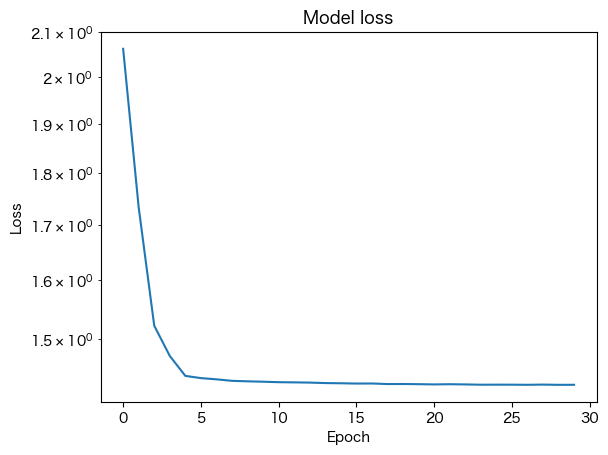

In [181]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.show()

In [182]:
#データの呼び出し
npz = np.load('test-data_(device-8)_(SNR_10-44-3).npz')

#データの格納
y_data = npz['arr_0']
t_data = npz['arr_1']

(test_datas, t_tests) = (y_data, t_data)

In [183]:
test_datas.shape , t_tests.shape

((12, 100000, 8), (12, 100000, 1))

In [184]:
#テスト(予測)

SER = np.empty((0, 1))
ACC = np.empty((0, 1))
answer = np.empty((12, len(y_data[0]), 8))

for i in tqdm.tqdm(range(len(test_datas))):
    error=0
    answer[i] = model.predict(y_data[i])
        
    for j in range(int(len(y_data[1]))):
        if np.argmax(answer[i][j]) != t_tests[i][j]:
            error+=1
            
    SER = np.append(SER, error/(len(y_data[0])))


100%|███████████████████████████████████████████| 12/12 [00:16<00:00,  1.35s/it]


In [185]:
SER

array([0.80717, 0.76615, 0.70997, 0.63809, 0.54877, 0.45014, 0.3576 ,
       0.28531, 0.24002, 0.22222, 0.22213, 0.2327 ])

In [186]:
#受信語データ保存
np.savez(f'Onehot_result_20-5.npz', SER)